In [37]:
state = {"Global Difficulty": 1000,
         "Aggregate Hashpower": 3000,
         "Regions": 3,
         "Zones per Region": 3,
         "Target Time": 2}

params = {"Block Difficulty Multiples": {"Prime": 1,
                                         "Region": .5,
                                         "Zone": .25},
        "Block Hash Multiplier Lognormal Distribution": {"mu": 0, "std": .05}
        }

In [36]:
# Add a log normal distribution for pertubing the hash needed
import numpy as np

def create_block_hashes(state, params):

    # Get the baseline block difficulties without randomness
    prime_block_hashes = [state["Global Difficulty"] * params["Block Difficulty Multiples"]["Prime"]]
    region_block_hashes = [state["Global Difficulty"] * params["Block Difficulty Multiples"]["Region"]] * state["Regions"]
    zone_block_hashes = [state["Global Difficulty"] * params["Block Difficulty Multiples"]["Zone"]]* state["Regions"] * state["Zones per Region"]

    # Merge and order
    block_hashes = []
    while len(region_block_hashes) > 0:
        for _ in range(state["Zones per Region"]):
            block_hashes.append(zone_block_hashes.pop())
        block_hashes.append(region_block_hashes.pop())
    block_hashes.append(prime_block_hashes.pop())

    # Add in randomness
    block_hashes = np.array(block_hashes)
    mutlipliers = np.random.lognormal(0, .05, len(block_hashes))
    block_hashes = block_hashes * mutlipliers
    block_hashes = block_hashes.round().astype(int)

    # Get cumulative sum for later computation of how far the aggregate hash rate gets us
    block_hashes_cs = np.cumsum(block_hashes)
    
    return block_hashes, block_hashes_cs

create_block_hashes(state, params)

(array([ 269,  244,  248,  475,  221,  270,  231,  502,  260,  231,  247,
         457, 1011]),
 array([ 269,  513,  761, 1236, 1457, 1727, 1958, 2460, 2720, 2951, 3198,
        3655, 4666]))

(array([5.400e+01, 4.380e+02, 1.658e+03, 3.037e+03, 2.908e+03, 1.430e+03,
        3.800e+02, 8.300e+01, 1.000e+01, 2.000e+00]),
 array([0.83821874, 0.87941952, 0.9206203 , 0.96182109, 1.00302187,
        1.04422265, 1.08542344, 1.12662422, 1.167825  , 1.20902579,
        1.25022657]),
 <BarContainer object of 10 artists>)

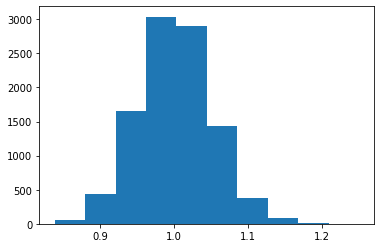

In [4]:
# Bisection to find the blocks processed

In [5]:
# If leftover blocks, the values get scaled by the change in difficulty